### Speaker encoder training

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset, Audio
import torchaudio
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print("CUDA is available")
else:
    print("CUDA is not available")  

CUDA is available


In [3]:
class CustomSpeakerEncoder(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=256, output_dim=512, num_layers=4, num_heads=8, dropout=0.1):
        super(CustomSpeakerEncoder, self).__init__()
        
        self.conv1 = nn.Conv1d(input_dim, 128, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.conv3 = nn.Conv1d(256, hidden_dim, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout), num_layers=num_layers
        )
        
        self.attention = nn.Linear(hidden_dim, 1)        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, mel_spectrogram):
        x = F.relu(self.bn1(self.conv1(mel_spectrogram))) 
        x = F.relu(self.bn2(self.conv2(x)))                
        x = F.relu(self.bn3(self.conv3(x)))                       
        x = x.transpose(1, 2) 
        
        transformer_out = self.transformer_encoder(x) 
        
        attention_weights = F.softmax(self.attention(transformer_out), dim=1)  
        pooled = torch.sum(attention_weights * transformer_out, dim=1)  
        
        x = F.relu(self.fc1(pooled))  
        x = self.dropout(x)
        speaker_embedding = self.fc2(x)         
        speaker_embedding = F.normalize(speaker_embedding, p=2, dim=1)
        
        return speaker_embedding

In [4]:
class SpeakerClassifier(nn.Module):
    def __init__(self, embedding_dim=512, num_speakers=100):
        super(SpeakerClassifier, self).__init__()
        self.fc = nn.Linear(embedding_dim, num_speakers)
        
    def forward(self, embeddings):        
        return self.fc(embeddings)

In [5]:
def extract_mel_spectrogram(waveform, sample_rate=16000, n_mels=80):
    if not isinstance(waveform, torch.Tensor):
        waveform = torch.tensor(waveform, dtype=torch.float32)
    
    waveform = waveform.unsqueeze(0)
    
    mel_transform = torchaudio.transforms.MelSpectrogram(n_mels=n_mels)
    
    mel_spec = mel_transform(waveform)
    mel_spec = torch.log1p(mel_spec)
    mel_spec = mel_spec.squeeze(0)
    
    return mel_spec

In [6]:
class SpeakerDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        mel_spec = extract_mel_spectrogram(item["audio"]["array"])
        speaker_id = item["speaker_id"]
        return mel_spec, speaker_id

In [7]:
def collate_fn(batch):
    # Pad mel spectrograms to same length in batch
    mel_specs, speaker_ids = zip(*batch)    
    max_len = max([mel.shape[1] for mel in mel_specs])
    max_len = min(max_len, 500) 
    
    # Pad or truncate
    padded_mels = []
    for mel in mel_specs:
        if mel.shape[1] > max_len:
            mel = mel[:, :max_len]  
        else:
            pad_len = max_len - mel.shape[1]
            if pad_len > 0:
                mel = F.pad(mel, (0, pad_len), value=0) 
        padded_mels.append(mel)
    
    mel_batch = torch.stack(padded_mels)
    speaker_ids = torch.tensor(speaker_ids, dtype=torch.long)
    
    return mel_batch, speaker_ids

In [40]:
from sklearn.model_selection import train_test_split
import pickle
import numpy as np

torch.manual_seed(5)
np.random.seed(5)

dataset = load_dataset("openslr/librispeech_asr", "clean", split="train.100", streaming=True)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

subset = list(dataset.take(int(1e4)))

train_subset, val_subset = train_test_split(subset, test_size=0.1, random_state=42)

trained_speaker_ids = set()
for item in train_subset:
    trained_speaker_ids.add(item["speaker_id"])
print("observed speaker ids: ", trained_speaker_ids)

with open("train_speaker_ids", "w") as f:
    for item in trained_speaker_ids:
        f.write(f"{item}\n")

unique_speakers = list(set([item["speaker_id"] for item in subset]))
speaker_to_id = {speaker: idx for idx, speaker in enumerate(unique_speakers)}
num_speakers = len(unique_speakers)
print(f"Number of unique speakers: {num_speakers}")

for item in train_subset + val_subset:
    item["speaker_id"] = speaker_to_id[item["speaker_id"]]

train_dataset = SpeakerDataset(train_subset)
val_dataset = SpeakerDataset(val_subset)

train_loader = DataLoader(
    train_dataset, 
    batch_size=4,  
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

speaker_encoder = CustomSpeakerEncoder(
    input_dim=80,
    hidden_dim=128,  
    output_dim=512,
    num_layers=2, 
    dropout=0.1
).to(device)

classifier = SpeakerClassifier(
    embedding_dim=512,
    num_speakers=num_speakers
).to(device)

optimizer = torch.optim.Adam(
    list(speaker_encoder.parameters()) + list(classifier.parameters()),
    lr=1e-5
)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
speaker_encoder.train()
classifier.train()

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for mel_specs, speaker_ids in pbar:
        mel_specs = mel_specs.to(device)
        speaker_ids = speaker_ids.to(device)
        
        embeddings = speaker_encoder(mel_specs)
        logits = classifier(embeddings)
        
        loss = criterion(logits, speaker_ids)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = logits.max(1)
        correct += predicted.eq(speaker_ids).sum().item()
        total += speaker_ids.size(0)
        
        if total % 20 == 0:
            torch.cuda.empty_cache()
        
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{100.*correct/total:.2f}%"
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

    speaker_encoder.eval()
    classifier.eval()
    
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  
        for mel_specs, speaker_ids in val_loader:
            mel_specs = mel_specs.to(device)
            speaker_ids = speaker_ids.to(device)

            embeddings = speaker_encoder(mel_specs)
            logits = classifier(embeddings)

            loss = criterion(logits, speaker_ids)
            val_loss += loss.item()
            
            _, predicted = logits.max(1)
            val_correct += predicted.eq(speaker_ids).sum().item()
            val_total += speaker_ids.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    print(f"Validation - Epoch {epoch+1}: Loss = {avg_val_loss:.4f}, Accuracy = {val_accuracy:.2f}%")

    speaker_encoder.train()
    classifier.train()

output_file = "pretrained_speaker_encoder_8.pt"
torch.save(speaker_encoder.state_dict(), output_file)
print("Saved to: ", output_file)


Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

/home/jimmylevin2013/anaconda3/envs/ruudenv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


observed speaker ids:  {7178, 1034, 1553, 19, 32, 8226, 6181, 3112, 5163, 1069, 8238, 5678, 5688, 1088, 4160, 8770, 5703, 5192, 587, 87, 1624, 89, 3168, 103, 4214, 5750, 8312, 7800, 8324, 2182, 3723, 3214, 7312, 5778, 2196, 150, 5789, 1183, 6818, 163, 3240, 3242, 4788, 6836, 7367, 4297, 5322, 201, 1743, 1246, 6367, 226, 233, 1263, 6385, 3830, 250, 4362, 5390, 6415, 8975, 5393, 7447, 2843, 307, 1334, 311, 6476, 8014, 5456, 7505, 1363, 374, 4481, 6529, 909, 3983, 403, 7067, 6563, 7078, 426, 2989, 446, 1992, 7113, 2514, 7635, 1502, 481, 5104}
Number of unique speakers: 91


Epoch 1/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:45<00:00, 49.82it/s, loss=4.4479, acc=11.00%]


Epoch 1: Loss = 4.4636, Accuracy = 11.00%
Validation - Epoch 1: Loss = 4.4115, Accuracy = 22.30%


Epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.90it/s, loss=4.2942, acc=29.78%]


Epoch 2: Loss = 4.3720, Accuracy = 29.78%
Validation - Epoch 2: Loss = 4.3182, Accuracy = 35.10%


Epoch 3/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.53it/s, loss=4.2343, acc=40.68%]


Epoch 3: Loss = 4.2882, Accuracy = 40.68%
Validation - Epoch 3: Loss = 4.2394, Accuracy = 41.90%


Epoch 4/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:47<00:00, 47.85it/s, loss=4.2161, acc=47.74%]


Epoch 4: Loss = 4.2159, Accuracy = 47.74%
Validation - Epoch 4: Loss = 4.1699, Accuracy = 48.60%


Epoch 5/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.03it/s, loss=4.1223, acc=52.74%]


Epoch 5: Loss = 4.1471, Accuracy = 52.74%
Validation - Epoch 5: Loss = 4.1017, Accuracy = 52.00%


Epoch 6/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.78it/s, loss=4.1666, acc=56.28%]


Epoch 6: Loss = 4.0797, Accuracy = 56.28%
Validation - Epoch 6: Loss = 4.0351, Accuracy = 53.70%


Epoch 7/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.48it/s, loss=4.0320, acc=59.01%]


Epoch 7: Loss = 4.0133, Accuracy = 59.01%
Validation - Epoch 7: Loss = 3.9725, Accuracy = 54.70%


Epoch 8/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:47<00:00, 47.46it/s, loss=3.9369, acc=61.63%]


Epoch 8: Loss = 3.9472, Accuracy = 61.63%
Validation - Epoch 8: Loss = 3.9041, Accuracy = 59.10%


Epoch 9/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.05it/s, loss=3.9081, acc=63.73%]


Epoch 9: Loss = 3.8816, Accuracy = 63.73%
Validation - Epoch 9: Loss = 3.8407, Accuracy = 59.50%


Epoch 10/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 47.97it/s, loss=3.8473, acc=65.92%]


Epoch 10: Loss = 3.8161, Accuracy = 65.92%
Validation - Epoch 10: Loss = 3.7768, Accuracy = 62.90%


Epoch 11/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 47.89it/s, loss=3.8079, acc=68.14%]


Epoch 11: Loss = 3.7506, Accuracy = 68.14%
Validation - Epoch 11: Loss = 3.7123, Accuracy = 63.90%


Epoch 12/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.31it/s, loss=3.5955, acc=70.01%]


Epoch 12: Loss = 3.6854, Accuracy = 70.01%
Validation - Epoch 12: Loss = 3.6482, Accuracy = 66.10%


Epoch 13/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:48<00:00, 46.75it/s, loss=3.7419, acc=71.56%]


Epoch 13: Loss = 3.6207, Accuracy = 71.56%
Validation - Epoch 13: Loss = 3.5868, Accuracy = 67.20%


Epoch 14/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 47.94it/s, loss=3.4792, acc=72.88%]


Epoch 14: Loss = 3.5565, Accuracy = 72.88%
Validation - Epoch 14: Loss = 3.5252, Accuracy = 67.50%


Epoch 15/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:48<00:00, 46.76it/s, loss=3.4971, acc=74.43%]


Epoch 15: Loss = 3.4914, Accuracy = 74.43%
Validation - Epoch 15: Loss = 3.4597, Accuracy = 70.40%


Epoch 16/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.22it/s, loss=3.3897, acc=75.89%]


Epoch 16: Loss = 3.4271, Accuracy = 75.89%
Validation - Epoch 16: Loss = 3.3975, Accuracy = 72.10%


Epoch 17/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:47<00:00, 47.68it/s, loss=3.2998, acc=76.96%]


Epoch 17: Loss = 3.3631, Accuracy = 76.96%
Validation - Epoch 17: Loss = 3.3394, Accuracy = 71.20%


Epoch 18/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.16it/s, loss=3.0396, acc=78.23%]


Epoch 18: Loss = 3.2997, Accuracy = 78.23%
Validation - Epoch 18: Loss = 3.2782, Accuracy = 71.70%


Epoch 19/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 48.31it/s, loss=3.3477, acc=78.48%]


Epoch 19: Loss = 3.2346, Accuracy = 78.48%
Validation - Epoch 19: Loss = 3.2109, Accuracy = 74.00%


Epoch 20/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2250/2250 [00:46<00:00, 47.95it/s, loss=3.2076, acc=79.91%]


Epoch 20: Loss = 3.1721, Accuracy = 79.91%
Validation - Epoch 20: Loss = 3.1522, Accuracy = 74.20%
Saved to:  pretrained_speaker_encoder_8.pt


### Integration with text2speech

In [8]:
encoder_file_name = "pretrained_speaker_encoder_8.pt"
huggingface_token = TOKEN
model_name = MODEL_NAME

In [9]:
custom_speaker_encoder = CustomSpeakerEncoder(
    input_dim=80,
    hidden_dim=128,
    output_dim=512,
    num_layers=2,
    dropout=0.1
).to(device)

custom_speaker_encoder.load_state_dict(torch.load(encoder_file_name, map_location=device))
custom_speaker_encoder.eval()  

/home/jimmylevin2013/anaconda3/envs/ruudenv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


CustomSpeakerEncoder(
  (conv1): Conv1d(80, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128

In [10]:
from datasets import load_dataset, Audio, Dataset

from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, Seq2SeqTrainingArguments, Seq2SeqTrainer
from huggingface_hub import login
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import numpy as np

In [11]:
torch.manual_seed(5)
np.random.seed(5)

dataset = load_dataset("openslr/librispeech_asr", "clean", split="train.100", streaming=True)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset = dataset.take(int(3e3))

print("Got the data")

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Got the data


In [12]:
def create_speaker_embedding(waveform, return_numpy=True):
    with torch.no_grad():
        mel_spec = extract_mel_spectrogram(waveform)
        mel_spec = mel_spec.unsqueeze(0).to(device)         
        speaker_embedding = custom_speaker_encoder(mel_spec)
        speaker_embedding = speaker_embedding.squeeze()
        
        if return_numpy:
            return speaker_embedding.cpu().numpy()
        else:
            return speaker_embedding 

In [13]:
# from huggingface
checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [14]:
# from huggingface
def prepare_dataset(example):
    audio = example["audio"]
    
    example = processor(
        text=example["text"],        
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension    
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector    
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])
    
    return example

In [15]:
# from huggingface
print("Processing data")

dataset = dataset.map(prepare_dataset, remove_columns=["file", "audio", "text", "speaker_id", "chapter_id"])

def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

dataset = Dataset.from_list(list(dataset))
dataset = dataset.train_test_split(test_size=0.1)

train_ids = set([item["id"] for item in dataset["train"]])
test_ids = set([item["id"] for item in dataset["test"]])

print("applied train-test split")


Processing data


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: adb9f336-18c5-42da-b9e2-b3cf429f5a58)')' thrown while requesting GET https://huggingface.co/datasets/openslr/librispeech_asr/resolve/71cacbfb7e2354c4226d01e70d77d5fca3d04ba1/clean/train.100/0000.parquet
Retrying in 1s [Retry 1/5].


applied train-test split


In [16]:
with open("train_ids", "w") as f:
    for item in train_ids:
        f.write(f"{item}\n")

with open("test_ids", "w") as f:
    for item in test_ids:
        f.write(f"{item}\n")

In [17]:
# from huggingface
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any
    
    def __call__(self, features: list[dict[str, Union[list[int], torch.Tensor]]]) -> dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]
        
        # collate the inputs and targets into a batch
        batch = processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")
        
        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100)
        
        # not used during fine-tuning
        del batch["decoder_attention_mask"]
        
        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths = target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings        
        batch["speaker_embeddings"] = torch.tensor(speaker_features)
        
        return batch

data_collator = TTSDataCollatorWithPadding(processor=processor)

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)
model.config.use_cache = False

# from huggingface
training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_librispeech_custom_8",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    #warmup_steps=500,    
    warmup_steps=250,
    #max_steps=4000,
    max_steps=2000,    
    #gradient_checkpointing=True,    
    gradient_checkpointing=False,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=2,
    #save_steps=1000,
    #eval_steps=1000,
    #save_steps=500,
    save_steps=2000,    
    eval_steps=500,    
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

login(token=huggingface_token)

# from huggingface
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    processing_class=processor,
)

print("Starting training")

trainer.train()

model.save_pretrained(model_name)
processor.save_pretrained(model_name)

trainer.push_to_hub()

Starting training


Step,Training Loss,Validation Loss
500,0.443900,0.400708
1000,0.426300,0.391597
1500,0.417800,0.386266
2000,0.412700,0.386056


/home/jimmylevin2013/anaconda3/envs/ruudenv/lib/python3.12/site-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/andymcgullen/speecht5_finetuned_librispeech_custom_8/commit/f5ab10582d45df9a6229bcc60ded87c38a63a2a0', commit_message='End of training', commit_description='', oid='f5ab10582d45df9a6229bcc60ded87c38a63a2a0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/andymcgullen/speecht5_finetuned_librispeech_custom_8', endpoint='https://huggingface.co', repo_type='model', repo_id='andymcgullen/speecht5_finetuned_librispeech_custom_8'), pr_revision=None, pr_num=None)

### Inference

In [53]:
encoder_file_name = "pretrained_speaker_encoder_8.pt"
huggingface_token = TOKEN
model_name = MODEL_NAME

# get speech ids from text-to-speech training and testing
if "train_ids" not in globals():
    train_ids = []
    with open("train_ids", "r") as f:
        train_ids = [line.strip() for line in f]
    train_ids = set(train_ids)
if "test_ids" not in globals():
    train_ids = []
    with open("test_ids", "r") as f:
        test_ids = [line.strip() for line in f]
    test_ids = set(test_ids)

# get speaker ids from speech encoder training
if "trained_speaker_ids" not in globals():
    trained_speaker_ids = []
    with open("train_speaker_ids", "r") as f:
        trained_speaker_ids = [int(line.strip()) for line in f]
    trained_speaker_ids = set(trained_speaker_ids)

print("trained speaker ids: ", trained_speaker_ids)

trained speaker ids:  {7178, 1034, 1553, 19, 32, 8226, 6181, 3112, 5163, 1069, 8238, 5678, 5688, 1088, 4160, 8770, 5703, 5192, 587, 87, 1624, 89, 3168, 103, 4214, 5750, 7800, 8312, 8324, 2182, 3723, 3214, 7312, 5778, 2196, 150, 5789, 1183, 6818, 163, 3240, 3242, 4788, 6836, 7367, 4297, 5322, 201, 1743, 1246, 6367, 226, 233, 1263, 6385, 3830, 250, 4362, 5390, 6415, 8975, 5393, 7447, 2843, 307, 1334, 311, 6476, 8014, 5456, 7505, 1363, 374, 4481, 6529, 909, 3983, 403, 7067, 6563, 7078, 426, 2989, 446, 1992, 7113, 2514, 7635, 1502, 481, 5104}


In [144]:
custom_speaker_encoder = CustomSpeakerEncoder(
    input_dim=80,
    hidden_dim=128,
    output_dim=512,
    num_layers=2,
    dropout=0.1
).to(device)

custom_speaker_encoder.load_state_dict(torch.load(encoder_file_name, map_location=device))
custom_speaker_encoder.eval()  

from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
from datasets import load_dataset, Audio as AudioFeature
import numpy as np

processor = SpeechT5Processor.from_pretrained(model_name)
model = SpeechT5ForTextToSpeech.from_pretrained(model_name).to(device)
model.eval()

# vocoder for converting to audio
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)
vocoder.eval()

def synthesize_speech(text, reference_audio_array, sample_rate=16000, numpy_return=True):   

    mel_spec = extract_mel_spectrogram(reference_audio_array, sample_rate)
    mel_spec = mel_spec.unsqueeze(0).to(device)
    
    with torch.no_grad():
        speaker_embeddings = custom_speaker_encoder(mel_spec)
        
    inputs = processor(text=text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    
    with torch.no_grad():
        spectrogram = model.generate_speech(input_ids, speaker_embeddings, vocoder=vocoder)

    if numpy_return:
        return spectrogram.cpu().numpy()
    else:
        return spectrogram

/home/jimmylevin2013/anaconda3/envs/ruudenv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [165]:
#dataset = load_dataset("openslr/librispeech_asr", "clean", split="train.100", streaming=True)
dataset = load_dataset("openslr/librispeech_asr", "clean", split="test", streaming=True)
dataset = dataset.cast_column("audio", AudioFeature(sampling_rate=16000))
dataset = dataset.take(int(1e3))
dataset = dataset.map(prepare_dataset) 
dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

dataset = Dataset.from_list(list(dataset))

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

In [166]:
import librosa

def load_audio_librosa(path, target_sr=None):
    y, sr = librosa.load(path, sr=target_sr)  # mono
    wav = torch.from_numpy(y).unsqueeze(0)    # (1, T)
    return wav, sr

def compute_speaker_similarity_ecapa(path_a, path_b):

    classifier = EncoderClassifier.from_hparams(
        source="speechbrain/spkrec-ecapa-voxceleb",
        run_opts={"device": DEVICE},
    )

    # ECAPA model expects 16kHz mono
    wav_a, _ = load_audio_librosa(path_a, target_sr=16000)
    wav_b, _ = load_audio_librosa(path_b, target_sr=16000)

    wav_a = wav_a.to(DEVICE)
    wav_b = wav_b.to(DEVICE)

    with torch.no_grad():
        emb_a = classifier.encode_batch(wav_a).squeeze(0)
        emb_b = classifier.encode_batch(wav_b).squeeze(0)

    if emb_a.ndim == 2:
        emb_a = emb_a.mean(dim=0)
    if emb_b.ndim == 2:
        emb_b = emb_b.mean(dim=0)

    emb_a = emb_a / emb_a.norm(p=2)
    emb_b = emb_b / emb_b.norm(p=2)

    cos_sim = F.cosine_similarity(
        emb_a.unsqueeze(0), emb_b.unsqueeze(0)
    ).item()

    return cos_sim

In [171]:
import scipy.io.wavfile as wav
from speechbrain.inference.classifiers import EncoderClassifier
from collections import defaultdict

DEVICE = device

ref_speaker_ids = set([])

similarities = defaultdict(list)
processed = 0
for i in range(len(dataset)):
    if processed == 40:  
    #if processed == 50:                
        break
    
    speaker_id = dataset[i]["speaker_id"]
    if speaker_id in ref_speaker_ids:
        continue

    if len(similarities[speaker_id]) > 8:
        continue
        
    ref_text = dataset[i]["text"]  

    max_chars = 200    
    if len(ref_text) > max_chars:
        continue       

    # make sure we don't select speaker ids that we saw earlier during speaker encoder training
    if dataset[i]["speaker_id"] in trained_speaker_ids:
        continue
    #if dataset[i]["speaker_id"] not in trained_speaker_ids:
    #    continue    
    
    # make sure we don't select text-to-speech samples that we saw earlier during text-to-speech training
    if dataset[i]["id"] in train_ids:
        continue
    
    ref_audio = np.array(dataset[i]["audio"]["array"])

    try:
        gen_audio = synthesize_speech(ref_text, ref_audio)    
        fileName_ref = f"ref_audio/ref_audio{i}.wav"
        wav.write(fileName_ref, 16000, ref_audio)        
        fileName_gen = f"gen_audio/gen_audio{i}.wav"
        wav.write(fileName_gen, 16000, gen_audio)    

        similarity = compute_speaker_similarity_ecapa(fileName_gen, fileName_ref)
        print(speaker_id,  similarity)
        similarities[speaker_id].append(similarity)
    
        processed += 1
    except RuntimeError as e:
        print("skipping index ", dataset[i]["id"])
        continue


6930 -0.10406260192394257
6930 0.02646414190530777
6930 0.08970243483781815
skipping index  6930-75918-0005
6930 -0.030990203842520714
6930 -0.008050388656556606
6930 -0.006398260593414307
6930 0.028804535046219826
6930 -0.1288658082485199
6930 0.05238477885723114
1320 0.007244447246193886
1320 -0.060192953795194626
1320 -0.02718680165708065
1320 0.01585840806365013
1320 0.13693867623806
1320 0.05270868539810181
1320 0.11262469738721848
1320 0.06093413755297661
1320 0.02863042801618576
5639 0.026899918913841248
5639 0.19119104743003845
5639 0.035423047840595245
5639 0.0841929242014885
5639 0.07909074425697327
5639 -0.02077234908938408
5639 -0.004599457606673241
5639 0.130641371011734
5639 0.05214433744549751
260 0.13995492458343506
260 0.10750143229961395
260 0.12239846587181091
260 0.03524595499038696
260 0.10707270354032516
260 0.04748903214931488
260 0.08845917135477066
260 0.06356248259544373
260 0.0997188612818718
7729 0.11462759971618652
7729 0.14017750322818756
7729 0.1863027960

In [131]:
from IPython.display import Audio as IPythonAudio
IPythonAudio(np.array(ref_audio), rate=16000)  

In [132]:
IPythonAudio(np.array(gen_audio), rate=16000)  

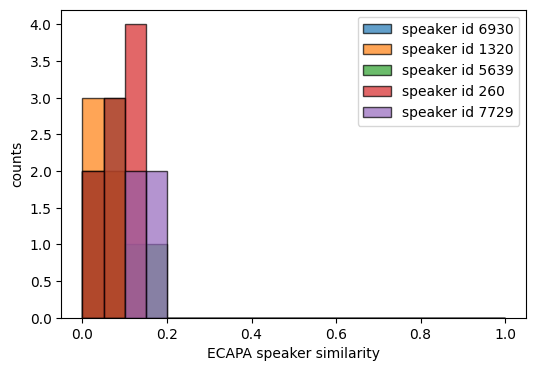

In [172]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
for speakerId in similarities.keys():
    if len(similarities[speakerId]) == 0:
        continue
    plt.hist(similarities[speakerId], label=f"speaker id {speakerId}", bins=np.linspace(0, 1, 21), alpha=0.7, edgecolor="black")
plt.legend()
plt.xlabel("ECAPA speaker similarity")
plt.ylabel("counts")
plt.savefig("speaker_similarities.png", format="png")